# The goal is to train a model able to convert T1 images to PBR PET images

In [1]:
%pip install wandb



Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob
from os.path import join as opj
from mpl_toolkits.axes_grid1 import ImageGrid
from unet3D import *
from torchsummary import summary
import monai
from monai.transforms import *
from mpl_toolkits.axes_grid1 import ImageGrid
import ssim
import tqdm

from sklearn.model_selection import train_test_split

from torchvision.utils import make_grid
from sklearn.model_selection import KFold

/home/matteo/anaconda3/envs/dreamfusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import wandb
wandb.login()

2023-05-30 16:24:47,258 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [4]:
mse_loss=nn.MSELoss()
ssim_loss = ssim.SSIM3D(window_size = 11)
bce_loss=nn.BCELoss()
fold=3


mse_weight=1.
bce_weight=1.
ssim_weight=0.

config={}


config["mse_weight"]=mse_weight
config["bce_weight"]=bce_weight
config["ssim_weight"]=ssim_weight
config["fold"]=fold

wandb.init(project="MRI2PET",config=config)

wandb: wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
base_path="/home/matteo/data/MRI-PET-AI/regressed_data"

cases=os.listdir(base_path)
exclude=['Scripts','temp','SubjectList.txt','Bay_7_Reconstruction_Log.xlsx','PBRKOA_KOA003_010818']

cases=[i for i in cases if i not in exclude]

### labels
HC -> 0

CLB -> 1

K0A -> 2

In [6]:
label_dict={"HC":0, "CLB":1, "KOA":2}

In [7]:
labels=[]
for c in cases:
    cl=None
    if "HC" in c:
        cl="HC"
    elif "CLB" in c:
        cl="CLB"
    elif "KOA" in c:
        cl="KOA"
    if cl is not None:
        labels.append(label_dict[cl])

In [8]:
cases=[os.path.join(base_path,i) for i in cases if i not in exclude]

In [9]:
len(labels),len(cases)

(203, 203)

(array([28.,  0.,  0.,  0.,  0., 88.,  0.,  0.,  0., 87.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

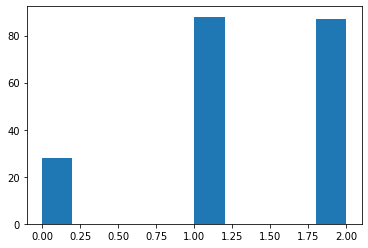

In [10]:
plt.hist(labels)

In [11]:
# train_cases,test_cases,train_labels,test_labels=train_test_split(cases,labels,test_size=0.15,random_state=42)
# train_cases,val_cases,train_labels,val_labels=train_test_split(cases,labels,test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using KFold from scikit-learn

fold_indices = list(kf.split(cases))  # Generate indices for splitting the data
    
train_indices, test_indices = fold_indices[fold]  # Select the fold indices

train_cases=np.array(cases)[train_indices]
test_cases=np.array(cases)[test_indices]
train_labels=np.array(labels)[train_indices]
test_labels=np.array(labels)[test_indices]


print(f"[INFO] train cases: {len(train_cases)} test cases: {len(test_cases)}")

[INFO] train cases: 163 test cases: 40


(array([ 2.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0., 17.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

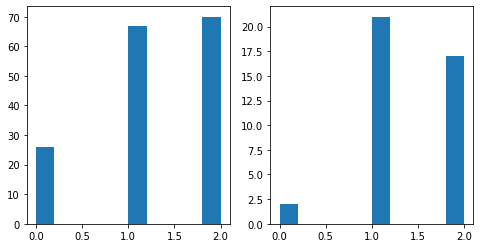

In [12]:
fig,axs=plt.subplots(1,2,figsize=(8,4))

axs[0].hist(train_labels)
axs[1].hist(test_labels)


## Load cases

Image crop

Normalization (In-sample) of T1 and PET






In [13]:
class MRIPETDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels,roi=(96,96,96), transform=None, target_transform=None,out_mask=True):
        self.paths = paths
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
        self.roi=roi
        self.out_mask=out_mask
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        
        images_path=glob.glob(opj(self.paths[idx],"*.nii.gz"))
        t1_path=[i for i in images_path if "T1" in i][0]
        pet_path=[i for i in images_path if "_suv_" in i][0]
        
        t1=nib.load(t1_path)
        pet=nib.load(pet_path)
        
        assert t1.shape==pet.shape
        half_shape=[s//2 for s in t1.shape]
        half_roi=[s//2 for s in self.roi]
        dim_0_start=half_shape[0]-half_roi[0]
        dim_0_end=half_shape[0]+half_roi[0]

        dim_1_start=half_shape[1]-half_roi[1]
        dim_1_end=half_shape[1]+half_roi[1]

        dim_2_start=half_shape[2]-half_roi[2]
        dim_2_end=half_shape[2]+half_roi[2]
        try:
            t1=t1.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        try:
            pet=pet.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        
        t1=torch.Tensor(np.expand_dims(t1,0))
        pet=torch.Tensor(np.expand_dims(pet,0))
        
        label=self.labels[idx]
        if self.transform:
            t1 = self.transform(t1)
        if self.target_transform:
            pet = self.target_transform(pet)
            
        if self.out_mask:
            mask=(t1>0)*1.
            return t1,pet,mask,label
        else:
            return t1,pet, label

In [14]:
BS=2
config["BS"]=BS

transform_mri=Compose([ScaleIntensityRangePercentiles(1,99,0,1)])
transform_pet=Compose([ScaleIntensity(0,1)])

train_dataset=MRIPETDataset(train_cases,train_labels,transform=transform_mri,target_transform=transform_pet)
test_dataset=MRIPETDataset(test_cases,test_labels,transform=transform_mri,target_transform=transform_pet)


train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=BS,shuffle=True)




In [15]:
sanity_check_dataloaders=False
if sanity_check_dataloaders:
    for t,p,m,l in tqdm.tqdm(train_dataloader):
        pass
    for t,p,m,l in tqdm.tqdm(test_dataloader):
        pass

## Model

In [16]:
n_channels=32
ch_mults=(1,1,1,1)
is_attn=(False,False,False,True)
n_blocks=1
depthwise_separable=True

config["n_channels"]=n_channels
config["ch_mults"]=ch_mults
config["is_attn"]=is_attn
config["n_blocks"]=n_blocks
config["depthwise_separable"]=depthwise_separable

model=UNet3D(image_channels=1,n_channels=n_channels,ch_mults=ch_mults,is_attn=is_attn,n_blocks=n_blocks,depthwise_separable=depthwise_separable)

device="cuda:0"
model=model.to(device)
summary(model,(1,96,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 96, 96, 96]             896
         GroupNorm-2       [-1, 32, 96, 96, 96]              64
             Swish-3       [-1, 32, 96, 96, 96]               0
            Conv3d-4       [-1, 32, 96, 96, 96]             896
            Conv3d-5       [-1, 32, 96, 96, 96]           1,056
    DepthSepConv3d-6       [-1, 32, 96, 96, 96]               0
         GroupNorm-7       [-1, 32, 96, 96, 96]              64
             Swish-8       [-1, 32, 96, 96, 96]               0
            Conv3d-9       [-1, 32, 96, 96, 96]             896
           Conv3d-10       [-1, 32, 96, 96, 96]           1,056
   DepthSepConv3d-11       [-1, 32, 96, 96, 96]               0
         Identity-12       [-1, 32, 96, 96, 96]               0
    ResidualBlock-13       [-1, 32, 96, 96, 96]               0
         Identity-14       [-1, 32, 96,

### Criterion and optimizers

In [17]:


def criterion(y_pred,y,mse_weight=mse_weight,bce_weight=bce_weight,ssim_weight=ssim_weight):
    return mse_weight*mse_loss(y_pred,y)+bce_weight*bce_loss(y_pred,y)+ssim_weight*ssim_loss(y_pred,y)


In [18]:
optim=torch.optim.Adam(model.parameters(),lr=1e-4)


### wandb log

In [19]:
def make_grid_images(example_pred,example_true):
    img_pred=make_grid(example_pred.permute(3,0,1,2).cpu())
    img_true=make_grid(example_true.permute(3,0,1,2).cpu())
    return img_pred,img_true
    

In [ ]:
EPOCHS=50
save_model=1
outdir=f"models_regressed/unet_t12pet_fold_{fold}"
os.makedirs(outdir,exist_ok=True)

loss_history=[]
val_loss_history=[]
# pbar=tqdm.tqdm(range(EPOCHS))
for epoch in range(EPOCHS):
    
    ## TRAINING
    
    pbar=tqdm.tqdm(train_dataloader)
    for x,y,m,l in pbar:
        
        optim.zero_grad()
        x,y,m=x.to(device),y.to(device),m.to(device)
        y_pred=model(x)
        #use the mask
        y_pred=m*y_pred
        
        #compute masked_loss
        loss=criterion(y_pred,m*y)
        loss.backward()
        optim.step()
        
        pbar.set_description(f"epoch {epoch} loss: {loss.item()}")
        loss_history.append(loss.item())
        wandb.log({"loss":loss.item()})
        
    ## VALIDATION
    
    with torch.no_grad():
        pbar_val=tqdm.tqdm(test_dataloader)
        for x,y,m,l in pbar_val:
        
        
            x,y,m=x.to(device),y.to(device),m.to(device)
            y_pred=model(x)
            #use the mask
            y_pred=m*y_pred

            #compute masked_loss
            loss=criterion(y_pred,m*y)
            mse=mse_loss(y_pred,m*y)
            ssim=ssim_loss(y_pred,m*y)
            bce=bce_loss(y_pred,m*y)

            pbar_val.set_description(f"val epoch {epoch} val loss: {loss.item()}")
            val_loss_history.append(loss.item())
            wandb.log({"val_loss":loss.item()})
            
            ## ADD LOG IMAGES
        example_true=y[0]
        example_pred=y_pred[0]
        img_pred,img_true=make_grid_images(example_pred,example_true)
        wandb.log({"original": wandb.Image(img_true.permute(1,2,0)), "reconstructed":wandb.Image(img_pred.permute(1,2,0))})
    
    if epoch%save_model==0:
        ## SAVE MODEL
        torch.save(model.state_dict(),f"{outdir}/{outdir}_{epoch}.pt")
    
    

epoch 5 loss: 0.10709124058485031:  34%|████████▌                | 28/82 [00:34<01:07,  1.25s/it]

In [ ]:
img_pred.shape

In [ ]:
torch.save(model.state_dict(),f"{outdir}/{outdir}_final_fold_{fold}.pt")

In [ ]:
model.cpu()